In [16]:
#導入所需資料庫
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
#使用(z_mean, z_log_var) 對 z 進行採樣，編碼一個數字的向量。
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
#編碼器
latent_dim = 2 #潛在空間的維度：一個平面

#編碼器layer層
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_7[0][0]']               
                                                                                            

In [19]:
#解碼器、layer層
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       3692

In [5]:
#將 VAE 定義為Model自定義train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
#開始訓練
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 111s 200ms/step - loss: 262.2480 - reconstruction_loss: 211.6115 - kl_loss: 2.8101
Epoch 2/30
547/547 [==============================] - 105s 192ms/step - loss: 190.5420 - reconstruction_loss: 185.6401 - kl_loss: 3.3581
Epoch 3/30
547/547 [==============================] - 98s 180ms/step - loss: 185.6978 - reconstruction_loss: 181.7113 - kl_loss: 3.5214
Epoch 4/30
547/547 [==============================] - 97s 178ms/step - loss: 184.0796 - reconstruction_loss: 179.7613 - kl_loss: 3.6211
Epoch 5/30
547/547 [==============================] - 99s 182ms/step - loss: 182.3385 - reconstruction_loss: 178.1621 - kl_loss: 3.6778
Epoch 6/30
547/547 [==============================] - 97s 178ms/step - loss: 180.8032 - reconstruction_loss: 176.5596 - kl_loss: 3.7345
Epoch 7/30
547/547 [==============================] - 96s 176ms/step - loss: 178.9912 - reconstruction_loss: 174.9754

In [22]:
#儲存模型
vae.save_weights('/content/drive/MyDrive/VAE.h5')

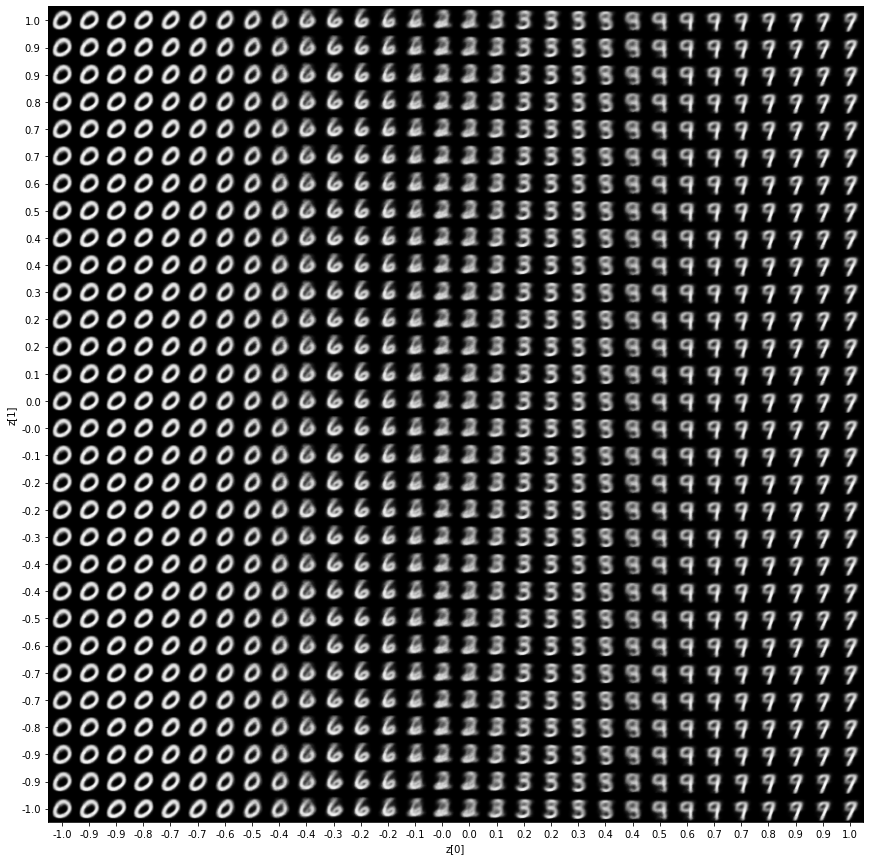

In [10]:
#輸出結果
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)